In [1]:
import tensorflow as tf
#tf.enable_eager_execution()

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

from nasbench.lib import cifar
from nasbench.lib import model_builder
from nasbench.lib import training_time
import numpy as np


from nasbench.lib import evaluate
from nasbench.lib import model_spec
from nasbench.lib import config as _config

from nasbench.scripts.run_evaluation import NumpyEncoder

import json

RESULTS_FILE = 'results.json'


In [13]:
import os
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [14]:
with tf.Session() as sess:
    devices = sess.list_devices()
    print(devices)

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 8310916958296660205), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7462775024594956907)]


In [15]:
config = _config.build_config()
config['train_epochs'] = 3

config['use_KD'] = False
config['use_tpu'] = False
config['train_data_files'] = [
    '../data/dataset/train_1.tfrecords',
    '../data/dataset/train_2.tfrecords',
    '../data/dataset/train_3.tfrecords',
    '../data/dataset/train_4.tfrecords']
config['valid_data_file'] = ['../data/dataset/validation.tfrecords']
config['test_data_file'] = ['../data/dataset/test.tfrecords']
config['sample_data_file'] = ['../data/dataset/sample.tfrecords']

matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
      [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
      [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
      [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
      [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
      [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
      [0, 0, 0, 0, 0, 0, 0]]   # output layer
# Operations at the vertices of the module, matches order of matrix
labels=['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'output']


matrix = np.array(matrix)
labels = np.array(labels)

spec = model_spec.ModelSpec(matrix, labels)
model_dir = '../my_model_dir_tmp'

In [16]:
from nasbench.lib.evaluate import _TrainAndEvaluator

In [17]:
evaluator = _TrainAndEvaluator(spec, config, model_dir)

INFO:tensorflow:Using config: {'_model_dir': '../my_model_dir_tmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 1073741824, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4a41ad9ac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=100, num_shards=2, num_cores_per_repli

In [18]:
meta = evaluator.run()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running train on CPU
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:training_loop marked as finished


KeyboardInterrupt: 

In [ ]:
[{k:v for k, v in res.items() if k != 'sample_metrics'} for res in meta['evaluation_results'] ]

In [9]:
WIDTH = 32
HEIGHT = 32
RGB_MEAN = [125.31, 122.95, 113.87]
RGB_STD = [62.99, 62.09, 66.70]

In [10]:
def _img_string_to_tensor(image_string):
    image = tf.decode_raw(image_string, tf.uint8)
    image.set_shape([3 * HEIGHT * WIDTH])
    image = tf.reshape(image, [3, HEIGHT, WIDTH])
    image = tf.transpose(image, [1, 2, 0])
    image = tf.cast(image, tf.float32)
    image -= tf.constant(RGB_MEAN, shape=[1, 1, 3])
    image /= tf.constant(RGB_STD, shape=[1, 1, 3])
    return image

In [51]:
# based on example from https://www.damienpontifex.com/posts/using-tensorflow-serving-to-host-our-retrained-image-classifier/
def serving_input_receiver_fn():
    
    feature_spec = {
        'image': tf.FixedLenFeature([], dtype=tf.string)
    }
    
    default_batch_size = None
    
    serialized_tf_example = tf.placeholder(
        dtype=tf.string, shape=[default_batch_size], 
        name='input_image_tensor')
    
    received_tensors = { 'images': serialized_tf_example }
    features = tf.parse_example(serialized_tf_example, feature_spec)
    
    
    
    features['image'] = tf.map_fn(_img_string_to_tensor, features['image'], dtype=tf.float32)
    print(features['image'])
    print(received_tensors)
    return tf.estimator.export.ServingInputReceiver(features, received_tensors)

In [52]:
serving_input_receiver_fn()

Tensor("map_7/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 32, 32, 3), dtype=float32)
{'images': <tf.Tensor 'input_image_tensor_7:0' shape=(?,) dtype=string>}


ServingInputReceiver(features={'image': <tf.Tensor 'map_7/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, 32, 32, 3) dtype=float32>}, receiver_tensors={'images': <tf.Tensor 'input_image_tensor_7:0' shape=(?,) dtype=string>}, receiver_tensors_alternatives=None)

In [11]:
feature_spec = {
        'image': tf.FixedLenFeature([], dtype=tf.string)
    }

In [12]:
serialized_tf_example = tf.placeholder(
        dtype=tf.string, shape=[1], 
        name='input_image_tensor')

In [13]:
received_tensors = { 'images': serialized_tf_example }

In [15]:
features = tf.parse_example(serialized_tf_example, feature_spec)

In [17]:
features['image'] = tf.map_fn(_img_string_to_tensor, features['image'], dtype=tf.float32)

In [18]:
tf.estimator.export.ServingInputReceiver(features, received_tensors)

ServingInputReceiver(features={'image': <tf.Tensor 'map/TensorArrayStack/TensorArrayGatherV3:0' shape=(1, 32, 32, 3) dtype=float32>}, receiver_tensors={'images': <tf.Tensor 'input_image_tensor:0' shape=(1,) dtype=string>}, receiver_tensors_alternatives=None)

In [21]:
serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)

In [22]:
serving_input_fn

<function tensorflow.python.estimator.export.export.build_parsing_serving_input_receiver_fn.<locals>.serving_input_receiver_fn()>

In [67]:
serving_input_fn

<function tensorflow.python.estimator.export.export.build_parsing_serving_input_receiver_fn.<locals>.serving_input_receiver_fn()>

In [53]:
%debug
evaluator.estimator.export_savedmodel('../exported_model', serving_input_receiver_fn)

> /home/fmsnew/miniconda3/envs/tf_nasbench/lib/python3.6/site-packages/tensorflow/python/framework/tensor_shape.py(37)__init__()
     35       raise TypeError("Cannot convert %s to Dimension" % value)
     36     else:
---> 37       self._value = int(value)
     38       if (not isinstance(value, compat.bytes_or_text_types) and
     39           self._value != value):

ipdb> value
'image'
ipdb> self._value
*** AttributeError: 'Dimension' object has no attribute '_value'
ipdb> self
*** AttributeError: 'Dimension' object has no attribute '_value'
ipdb> self
*** AttributeError: 'Dimension' object has no attribute '_value'
ipdb> value
'image'
ipdb> print(value)
image
ipdb> quite()
*** NameError: name 'quite' is not defined
ipdb> quit()
Tensor("map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 32, 32, 3), dtype=float32)
{'images': <tf.Tensor 'input_image_tensor:0' shape=(?,) dtype=string>}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU


ValueError: invalid literal for int() with base 10: 'image'

In [ ]:
value

{'train_data_files': ['train_1.tfrecords',
  'train_2.tfrecords',
  'train_3.tfrecords',
  'train_4.tfrecords'],
 'valid_data_file': ['validation.tfrecords'],
 'test_data_file': ['test.tfrecords'],
 'sample_data_file': ['sample.tfrecords'],
 'data_format': 'channels_last',
 'num_labels': 10,
 'module_vertices': 7,
 'max_edges': 9,
 'available_ops': ['conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3'],
 'stem_filter_size': 128,
 'num_stacks': 3,
 'num_modules_per_stack': 3,
 'batch_size': 256,
 'train_epochs': 1,
 'train_seconds': 14400.0,
 'learning_rate': 0.1,
 'lr_decay_method': 'COSINE_BY_STEP',
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'max_attempts': 5,
 'intermediate_evaluations': ['0.5'],
 'num_repeats': 3,
 'use_tpu': False,
 'tpu_iterations_per_loop': 100,
 'tpu_num_shards': 2}

NameError: name 'cifar' is not defined

In [8]:
input_sample = cifar.CIFARInput('sample', config)

In [9]:
dataset = input_sample.input_fn({'batch_size':10})

Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


In [10]:
dataset

<PrefetchDataset shapes: ((10, 32, 32, 3), (10,)), types: (tf.float32, tf.int32)>

In [11]:
for element in dataset: 
    #print(element)
    break

In [12]:
element[0].shape

TensorShape([Dimension(10), Dimension(32), Dimension(32), Dimension(3)])

In [13]:
element[1].shape

TensorShape([Dimension(10)])

In [7]:
config['train_data_files']

['train_1.tfrecords',
 'train_2.tfrecords',
 'train_3.tfrecords',
 'train_4.tfrecords']

In [8]:
config['valid_data_file']

['validation.tfrecords']

In [10]:
config['sample_data_file']

['sample.tfrecords']

In [11]:
config['test_data_file']

['test.tfrecords']

In [7]:
all_files = config['train_data_files'] + config['valid_data_file'] + config['sample_data_file'] + config['test_data_file']

In [8]:
all_files

['train_1.tfrecords',
 'train_2.tfrecords',
 'train_3.tfrecords',
 'train_4.tfrecords',
 'validation.tfrecords',
 'sample.tfrecords',
 'test.tfrecords']

In [9]:
file = all_files[0]

In [12]:
run_config = tf.contrib.tpu.RunConfig(model_dir=model_dir)

In [14]:
import functools

In [29]:
WIDTH = 32
HEIGHT = 32
RGB_MEAN = [125.31, 122.95, 113.87]
RGB_STD = [62.99, 62.09, 66.70]

In [30]:
def _preprocess(image):
  """Perform standard CIFAR preprocessing.

  Pads the image then performs a random crop.
  Then, image is flipped horizontally randomly.

  Args:
    image: image Tensor with shape [height, width, 3]

  Returns:
    preprocessed image with the same dimensions.
  """
  # Pad 4 pixels on all sides with 0
  image = tf.image.resize_image_with_crop_or_pad(
      image, HEIGHT + 8, WIDTH + 8)

  # Random crop
  image = tf.random_crop(image, [HEIGHT, WIDTH, 3], seed=0)

  # Random flip
  image = tf.image.random_flip_left_right(image, seed=0)

  return image


def _parser(use_preprocessing, serialized_example):
  """Parses a single tf.Example into image and label tensors."""
  features = tf.parse_single_example(
      serialized_example,
      features={
          'image': tf.FixedLenFeature([], tf.string),
          'label': tf.FixedLenFeature([], tf.int64),
      })
  image = tf.decode_raw(features['image'], tf.uint8)
  image.set_shape([3 * HEIGHT * WIDTH])
  image = tf.reshape(image, [3, HEIGHT, WIDTH])
  # TODO(chrisying): handle NCHW format
  image = tf.transpose(image, [1, 2, 0])
  image = tf.cast(image, tf.float32)
  if use_preprocessing:
    image = _preprocess(image)
  image -= tf.constant(RGB_MEAN, shape=[1, 1, 3])
  image /= tf.constant(RGB_STD, shape=[1, 1, 3])
  label = tf.cast(features['label'], tf.int32)
  return image, label

In [31]:
def _set_batch_dimension(batch_size, images, labels):
    images.set_shape(images.get_shape().merge_with(
      tf.TensorShape([batch_size, None, None, None])))
    labels.set_shape(labels.get_shape().merge_with(
      tf.TensorShape([batch_size])))

    return images, labels


In [46]:
params = {'file':file}

In [51]:
def _dummy_imput_fn(params):
    batch_size = params['batch_size']
    dataset = tf.data.TFRecordDataset(params['file'])
    dataset = dataset.prefetch(buffer_size=batch_size)

   
   # Parse, preprocess, and batch images
    parser_fn = functools.partial(_parser, False)
    dataset = dataset.apply(
        tf.contrib.data.map_and_batch(
            parser_fn,
            batch_size=batch_size,
            num_parallel_batches=None,
            drop_remainder=True))

    # Assign static batch size dimension
    dataset = dataset.map(functools.partial(_set_batch_dimension, batch_size))

    # Prefetch to overlap in-feed with training
    dataset = dataset.prefetch(tf.contrib.data.AUTOTUNE)
    

    return dataset

In [52]:
est = tf.contrib.tpu.TPUEstimator(
      use_tpu=False,
      model_fn=model_builder.build_model_fn(spec, config, None),
      config=run_config,
      params=params,
      train_batch_size=config['batch_size'],
      eval_batch_size=config['batch_size'],
      predict_batch_size=1000)

INFO:tensorflow:Using config: {'_model_dir': '../my_model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa64fdf9630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=2, num_shards=None, num_cores_per_replica=None, per_host_input_for_training=2, tpu_job_name=None, initial_infeed_sleep_secs=None, inpu

In [53]:
est_preds = est.predict(input_fn=_dummy_imput_fn, yield_single_examples=False)

In [54]:
all_pred_logits_aug = []
for preds in est_preds:
    all_pred_logits_aug.append(preds['logits'])
all_pred_logits_aug = np.vstack(all_pred_logits_aug)

Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../my_model_dir/model.ckpt-5625
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:prediction_loop

In [56]:
all_pred_logits_aug.shape

(10000, 10)

In [10]:
import tensorflow as tf

In [ ]:
tf.keras.losses.KLD

In [2]:
raw_dataset = tf.data.TFRecordDataset(file)

NameError: name 'tf' is not defined

In [3]:
raw_dataset

NameError: name 'raw_dataset' is not defined

In [1]:
cnt = 0
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  #print(example)
  #break
  cnt += 1
print(cnt)

NameError: name 'raw_dataset' is not defined

In [62]:
img = example.features.feature['image']

In [63]:
preds= all_pred_logits_aug[0]

In [64]:
feat_preds = tf.train.Feature(float_list=tf.train.FloatList(value=preds))

In [66]:
example = tf.train.Example(features=tf.train.Features(
          feature={
              'image': img,
              'label': feat_preds
          }))

In [67]:
example

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: ";+2Dbw\213\221\225\225\203}\216\220\211\201\211\206|\213\213\205\210\213\230\243\250\237\236\236\230\224\020\000\0223Xx\200\177~tjeiqmpwmi}\177z\203|y\203\204\205\205{wz\031\0201Sn\201\202yqppji\200|\202\177zsx\202\203\213\177~\177\202\216\202vxm!&Wjsuriky}mq\222\205\177vu\177z\204\211\210\203|\202\204\207\202}y^2;f\177|yxrk}\201jl|ylbnux\206\214\203\215\207\177ywgWKCGTn\201\210\203\201wlz{ikolb^aSXfaXv\214\210xkXC# ao{\202\210\204zy\177\212|xkPDJeiA:?N\210z\213\227\201l_`YBsw\202\214\205\177\212\211\203\205\206lH3)H\265\321}D@R{p\207\227\211rie~f\211\200\204\200w{\200\202y\211\203J62,V\313\331\242dMKJLk\207\207\201\177w}\206\232\232\234\214{}~\177\205\204Z?>FOg\230\224\215ye`VKe\210\210\206\205\204\200\205\232\233\234\223\205\211\213\206\215yPaZb\211\213\224\206\212\206\214\257\216fl\207\203\205\212\210\202\206\221\222\222\207\177\201ug\202xo\222\210\243\251\230\241\224\261\241\303\321\275}l\214\211

In [68]:
file

'train_1.tfrecords'

In [48]:
out_file = file.replace('.', '_KD.')

In [49]:
out_file

'train_1_KD.tfrecords'

In [ ]:
with tf.python_io.TFRecordWriter(out_file) as record_writer:
    

In [5]:
import tensorflow as tf

/home/fmsnew/miniconda3/envs/tf_nasbench/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmsnew/miniconda3/envs/tf_nasbench/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmsnew/miniconda3/envs/tf_nasbench/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fmsnew/miniconda3/envs

In [6]:
t = tf.constant([[[1, 1, 1], [2, 2, 2]],
                 [[3, 3, 3], [4, 4, 4]],
                 [[5, 5, 5], [6, 6, 6]]])


In [9]:
t[:, 0]

<tf.Tensor 'strided_slice_1:0' shape=(3, 3) dtype=int32>

In [38]:
preds = tf.convert_to_tensor(preds)

In [35]:
preds

<tf.Tensor: id=18, shape=(10,), dtype=float64, numpy=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])>

In [8]:
input_sample = cifar.CIFARInput('test', config)

In [9]:
input_valid = cifar.CIFARInput('valid', config)

In [10]:
input_sample.num_images

10000

In [11]:
run_config = tf.contrib.tpu.RunConfig(model_dir=model_dir)

In [12]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
#preds = evaluator.estimator.predict(input_fn=input_sample.input_fn, yield_single_examples=False)

In [14]:
with tf.device("/gpu:0"):
    est = tf.contrib.tpu.TPUEstimator(
      use_tpu=config['use_tpu'],
      model_fn=model_builder.build_model_fn(spec, config, None),
      config=run_config,
      train_batch_size=config['batch_size'],
      eval_batch_size=config['batch_size'],
      predict_batch_size=1000)

INFO:tensorflow:Using config: {'_model_dir': '../my_model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f497018cac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=2, num_shards=None, num_cores_per_replica=None, per_host_input_for_training=2, tpu_job_name=None, initial_infeed_sleep_secs=None, inpu

In [15]:
est_preds = est.predict(input_fn=input_sample.input_fn, yield_single_examples=False)

In [16]:
%%time
all_pred_logits = []
for preds in est_preds:
    all_pred_logits.append(preds['logits'])

all_pred_logits = np.vstack(all_pred_logits)

Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../my_model_dir/model.ckpt-5625
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:prediction_loop

In [18]:
all_pred_logits.shape

(10000, 10)

In [19]:
all_pred_logits

array([[-5.198497  , -0.5097906 ,  1.5927047 , ..., -2.7117019 ,
        -5.426718  , -8.701062  ],
       [ 4.69084   , 11.237216  , -7.6251645 , ..., -8.506753  ,
        25.315025  ,  0.8378946 ],
       [ 2.3660705 , 10.32973   , -3.7601194 , ..., -6.1430798 ,
        17.7709    ,  1.5142266 ],
       ...,
       [-4.2144613 , -3.9437613 ,  2.9157653 , ..., -0.07268898,
        -5.4365005 , -5.233665  ],
       [-0.25166565, 16.308798  ,  2.8823287 , ..., -4.9508986 ,
        -8.133484  , -1.2017008 ],
       [-6.170644  ,  0.2728765 , -4.923439  , ..., 20.768206  ,
        -6.193559  , -3.0751996 ]], dtype=float32)

In [20]:
est_preds = est.predict(input_fn=input_sample.input_fn_aug_always, yield_single_examples=False)

In [21]:
%%time
all_pred_logits_aug = []
for preds in est_preds:
    all_pred_logits_aug.append(preds['logits'])
all_pred_logits_aug = np.vstack(all_pred_logits_aug)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../my_model_dir/model.ckpt-5625
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:prediction_loop marked as finished
INFO:tensorflow:prediction_loop marked as finished
CPU

In [23]:
all_pred_logits_aug

array([[-4.1276937 , -2.35612   ,  1.9957058 , ..., -2.8184862 ,
        -6.9801183 , -7.462472  ],
       [ 4.917942  ,  8.729052  , -5.6273384 , ..., -6.691859  ,
        20.080475  ,  0.28911692],
       [ 3.663457  , 12.096933  , -5.2504654 , ..., -7.4851403 ,
        14.406055  ,  1.3366762 ],
       ...,
       [-3.1078632 , -3.8869143 ,  1.8350172 , ...,  0.14261226,
        -4.698581  , -4.1311646 ],
       [-1.3201159 , 15.807297  ,  1.998376  , ..., -3.6511786 ,
        -6.049607  , -1.5650008 ],
       [-6.2601013 , -1.0886393 , -3.4194243 , ..., 21.1696    ,
        -6.019027  , -2.9381714 ]], dtype=float32)

In [26]:
%matplotlib inline

In [27]:
import matplotlib.pyplot as plt

In [32]:
from scipy.special import softmax

In [39]:
softmax(all_pred_logits, axis=1).sum(axis=1)

array([0.9999993, 1.0000007, 0.9999993, ..., 1.       , 0.9999998,
       1.0000002], dtype=float32)

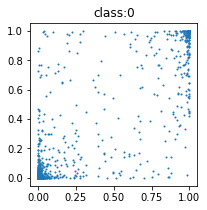

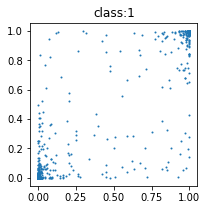

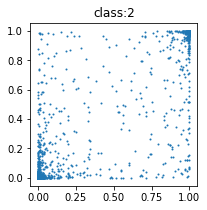

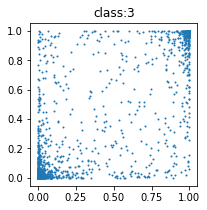

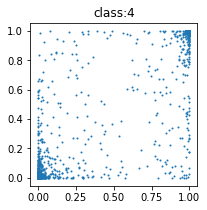

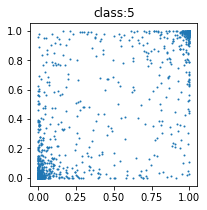

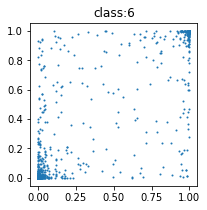

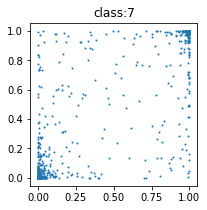

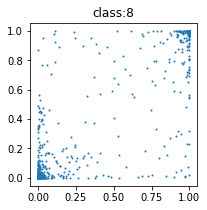

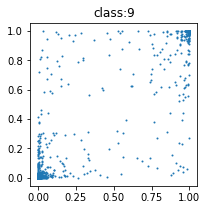

In [41]:
for i in range(10):
    plt.figure(figsize=(3, 3))
    plt.scatter(softmax(all_pred_logits, axis=1)[:, i], softmax(all_pred_logits_aug, axis=1)[:, i], s=1)
    plt.title(f'class:{i}')

In [25]:
input_sample = cifar.CIFARInput('sample', config)

In [31]:
input_sample.input_fn({'batch_size':10})

<PrefetchDataset shapes: ((10, 32, 32, 3), (10,)), types: (tf.float32, tf.int32)>

In [60]:
est = tf.contrib.tpu.TPUEstimator(
      use_tpu=config['use_tpu'],
      model_fn=model_builder.build_model_fn(spec, config, None),
      config=run_config,
      train_batch_size=config['batch_size'],
      eval_batch_size=config['batch_size'],
      predict_batch_size=1000)

INFO:tensorflow:Using config: {'_model_dir': '../my_model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f03f678b908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=2, num_shards=None, num_cores_per_replica=None, per_host_input_for_training=2, tpu_job_name=None, initial_infeed_sleep_secs=None, inpu

In [71]:
def _make_logits(images, labels):
    
    def _kd_input_fn(params):
        return tf.data.Dataset.from_tensors(images)
    
    est_preds = est.predict(input_fn=_kd_input_fn, yield_single_examples=False)
    
    all_pred_logits = []
    for preds in est_preds:
        all_pred_logits.append(preds['logits'])
        
    all_pred_logits = np.vstack(all_pred_logits)
    
    logits = tf.convert_to_tensor(all_pred_logits)
    
    return images, logits

In [72]:
def input_fn(params):
    batch_size = params['batch_size']
    is_training = (params['mode'] == 'train' or params['mode'] == 'augment')

    dataset = tf.data.TFRecordDataset(params['data_files'])
    dataset = dataset.prefetch(buffer_size=batch_size)

    # Repeat dataset for training modes
    if is_training:
      # Shuffle buffer with whole dataset to ensure full randomness per epoch
      dataset = dataset.cache().apply(
          tf.contrib.data.shuffle_and_repeat(
              buffer_size=params['num_images']))

    # This is a hack to allow computing metrics on a fixed batch on TPU. Because
    # TPU shards the batch acrosss cores, we replicate the fixed batch so that
    # each core contains the whole batch.
    if params['mode'] == 'sample':
        dataset = dataset.repeat()

    # Parse, preprocess, and batch images
    parser_fn = functools.partial(_parser, is_training)
    dataset = dataset.apply(
        tf.contrib.data.map_and_batch(
            parser_fn,
            batch_size=batch_size,
            num_parallel_batches=None,
            drop_remainder=True))

    # Assign static batch size dimension
    dataset = dataset.map(functools.partial(_set_batch_dimension, batch_size))

    # Prefetch to overlap in-feed with training
    dataset = dataset.prefetch(tf.contrib.data.AUTOTUNE)
    
    # make logits for KD
    dataset = dataset.map(_make_logits)

    return dataset

In [73]:
dataset = input_fn(params)

INFO:tensorflow:Error recorded from prediction_loop: Tensor("IteratorV2:0", shape=(), dtype=resource) must be from the same graph as Tensor("TensorDataset:0", shape=(), dtype=variant).
INFO:tensorflow:prediction_loop marked as finished


ValueError: Tensor("IteratorV2:0", shape=(), dtype=resource) must be from the same graph as Tensor("TensorDataset:0", shape=(), dtype=variant).

In [67]:
dataset

<MapDataset shapes: ((1000, 32, 32, 3), (1000,)), types: (tf.float32, tf.int32)>

In [7]:
preds['logits'].shape

NameError: name 'preds' is not defined

In [106]:
%%time
with tf.device("/gpu:0"):
    preds = next(est_preds)

CPU times: user 540 ms, sys: 60 ms, total: 600 ms
Wall time: 313 ms


In [107]:
%%time
with tf.device("/gpu:0"):
    preds = next(est_preds)

CPU times: user 696 ms, sys: 60 ms, total: 756 ms
Wall time: 304 ms


In [109]:
est_preds = est.predict(input_fn=input_valid.input_fn, yield_single_examples=False)

In [110]:
%%time
with tf.device("/gpu:0"):
    preds = next(est_preds)

INFO:tensorflow:prediction_loop marked as finished
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]


Exception ignored in: <generator object Estimator.predict at 0x7fea7be61f68>
Traceback (most recent call last):
  File "/home/fmsnew/miniconda3/envs/tf_nasbench/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 605, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "/home/fmsnew/miniconda3/envs/tf_nasbench/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/fmsnew/miniconda3/envs/tf_nasbench/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 5229, in get_controller
    yield g
  File "/home/fmsnew/miniconda3/envs/tf_nasbench/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/fmsnew/miniconda3/envs/tf_nasbench/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 5045, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow.python.framework.o

INFO:tensorflow:vertex_channels: [128, 32, 32, 32, 32, 32, 128]
INFO:tensorflow:vertex_channels: [128, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 64, 64, 64, 64, 64, 256]
INFO:tensorflow:vertex_channels: [256, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:vertex_channels: [512, 128, 128, 128, 128, 128, 512]
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../my_model_dir/model.ckpt-156
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
CPU times: user 5.15 s, sys: 148 ms, total: 5.3 s
Wall time: 4.6 s


In [18]:
preds['logits'].shape

(100, 10)

In [44]:
dataset = tf.data.TFRecordDataset(config['sample_data_file'])

In [45]:
for element in dataset: 
    #print(element)
    break

In [46]:
image, label = cifar._parser(False, element)

In [47]:
image.shape

TensorShape([Dimension(32), Dimension(32), Dimension(3)])

In [48]:
label

<tf.Tensor: id=114641, shape=(), dtype=int32, numpy=0>

In [ ]:
for element in dataset: 
    #print(element)
    break